<a href="https://colab.research.google.com/github/AlanFabian1/Julian/blob/main/Joaquin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Crime

El presente documento detalla el flujo y transformacion de los datos desde la fuente hasta el software de Presentación de los datos.

## 0. Preparación del ambiente e Importación de datos.

El concentrado de datos de la Fiscalía proviene de una base de datos pública perteneciente al gobierno de la Ciudad de México, y se puede automatizar su obtención con el siguiente comando:

In [45]:
!wget https://archivo.datos.cdmx.gob.mx/FGJ/carpetas/carpetasFGJ_acumulado_2024_09.csv

--2024-10-26 17:31:28--  https://archivo.datos.cdmx.gob.mx/FGJ/carpetas/carpetasFGJ_acumulado_2024_09.csv
Resolving archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)... 189.240.234.120
Connecting to archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)|189.240.234.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 560989551 (535M) [text/csv]
Saving to: ‘carpetasFGJ_acumulado_2024_09.csv.2’

carpetasFGJ_acumula 100%[===================>] 535.00M  35.3MB/s    in 40s     

2024-10-26 17:32:09 (13.3 MB/s) - ‘carpetasFGJ_acumulado_2024_09.csv.2’ saved [560989551/560989551]



Toda la exploración de datos, así como su transformación se realizó en el lenguaje de Python, y una serie de librerías "reelevantes" se encuentran integradas por defecto en este ambiente, como lo es:
- Pandas
- MatplotLib
- Numpy
- DateTime

Pero, Deus Ex Machina utilizó la herramienta de Pycaret para realizar los modelos predictivos del comportamiento de actividades delictivas.

Esta librería, es necesario importarla desde un repositorio externo, con apoyo del comando pip

In [46]:
!pip install pycaret[full]

## 1. Limpieza de datos

### 1. Preparación de los datos y el ambiente

Si bien el ambiente ya tiene cargadas algunas de las principales librerías de Python, es importante declararlas en el contexto actual para utilizarlas, a continuación se importarán todas las librerías utilizadas por este proyecto.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pycaret.regression import *
from pycaret.time_series import *

Además, una forma sencilla de manipular los datos es mediante el uso de los DataFrames, objetos de la librería Pandas especializados en el manejo de Bases de datos o matrices de información.

In [48]:
data = pd.read_csv('/content/carpetasFGJ_acumulado_2024_09.csv')

### 2. Exploración Inicial

Parte importante previo a la limpieza de datos es conocer la estructura de los datos, o, en este caso, los datos que cada registro contiene.

In [49]:
print(data.columns)

Index(['anio_inicio', 'mes_inicio', 'fecha_inicio', 'hora_inicio',
       'anio_hecho', 'mes_hecho', 'fecha_hecho', 'hora_hecho', 'delito',
       'categoria_delito', 'competencia', 'fiscalia', 'agencia',
       'unidad_investigacion', 'colonia_hecho', 'colonia_catalogo',
       'alcaldia_hecho', 'alcaldia_catalogo', 'municipio_hecho', 'latitud',
       'longitud'],
      dtype='object')


Además es importante entender que tipo de datos maneja cada columna , para poder manipularlas acorde a estas características.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025785 entries, 0 to 2025784
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   anio_inicio           int64  
 1   mes_inicio            object 
 2   fecha_inicio          object 
 3   hora_inicio           object 
 4   anio_hecho            float64
 5   mes_hecho             object 
 6   fecha_hecho           object 
 7   hora_hecho            object 
 8   delito                object 
 9   categoria_delito      object 
 10  competencia           object 
 11  fiscalia              object 
 12  agencia               object 
 13  unidad_investigacion  object 
 14  colonia_hecho         object 
 15  colonia_catalogo      object 
 16  alcaldia_hecho        object 
 17  alcaldia_catalogo     object 
 18  municipio_hecho       object 
 19  latitud               float64
 20  longitud              float64
dtypes: float64(3), int64(1), object(17)
memory usage: 324.6+ MB


Finalmente, como parte de la exploración inicial, es bueno conocer las dimensiones de nuestra matriz de datos, o, en este caso, el numero de registros que tenemos.

In [51]:
data.shape

(2025785, 21)

### 3. Manejo de Valores Nulos

En todo proyecto de análisis de datos se encuentran casos dónde una serie de registros contienen información que resulta poco significativa o incluso disruptiva para el análisis, por lo que es necesario tener un mecanismo de procesamiento de estos casos especiales.

És por ello que, como primer paso, se explora o se hace un conteo general de cuantos valores nulos hay.

In [52]:
data.isnull().sum()

,0
anio_inicio,0
mes_inicio,0
fecha_inicio,3
hora_inicio,15
anio_hecho,545
mes_hecho,545
fecha_hecho,546
hora_hecho,885
delito,0
categoria_delito,0


Debido a nuestro objetivo de análisis de patrones de crimen, entendimos que los datos primordiales son: La localización temporal y geopolítica, centrándonos en la fecha del delito sucedido y la Colonia y/o Alcaldía dónde sucedió respectivamente.

Se decidió de agrupar aquellos casos que no tienen una hora definida, pero se considerarían útiles mientras el día sí estuviera definido. En el caso de no tener un día definido, se consideraría intrazable el delito y se elimina el registro.

In [53]:
df_not_fecha_null = data.dropna(subset=['fecha_hecho'])
df_not_fecha_null.isnull().sum()

,0
anio_inicio,0
mes_inicio,0
fecha_inicio,3
hora_inicio,15
anio_hecho,0
mes_hecho,0
fecha_hecho,0
hora_hecho,339
delito,0
categoria_delito,0


In [54]:
df_count = df_not_fecha_null[['municipio_hecho','anio_inicio']].groupby(['municipio_hecho']).count().sort_values('anio_inicio',ascending=False)
df_count

,anio_inicio
municipio_hecho,
CDMX,2001854
NEZAHUALCOYOTL,2395
TLALNEPANTLA DE BAZ,2231
ECATEPEC DE MORELOS,1943
NAUCALPAN DE JUAREZ,1632
...,...
MONCLOVA,1
MIXQUIAHUALA DE JUAREZ,1
MINERAL DEL MONTE,1


Otro filtro importante que encontramos, fue el tema de la localización. Debido al requerimiento establecido, se acordó que este estudio se limitaría a la Ciudad de México, y dado que este parámetro puede apoyar a decrementar el número de registros con valores nulos con respecto a las coordenadas geográficas o localización geopolítica, se decidió filtrar aquellos registros fuera del área de interés.

In [55]:
df_cdmx = df_not_fecha_null.loc[df_not_fecha_null['municipio_hecho'] == 'CDMX'].reset_index(drop=True)
df_cdmx.shape

(2001854, 21)

In [56]:
df_cdmx.isnull().sum()

,0
anio_inicio,0
mes_inicio,0
fecha_inicio,3
hora_inicio,13
anio_hecho,0
mes_hecho,0
fecha_hecho,0
hora_hecho,329
delito,0
categoria_delito,0


In [57]:

df_cdmx['alcaldia_hecho'].unique()

array(['TLALPAN', 'IZTAPALAPA', 'GUSTAVO A. MADERO', 'BENITO JUAREZ',
       'COYOACAN', 'MIGUEL HIDALGO', 'AZCAPOTZALCO',
       'VENUSTIANO CARRANZA', 'IZTACALCO', 'ALVARO OBREGON', 'CUAUHTEMOC',
       'XOCHIMILCO', 'LA MAGDALENA CONTRERAS', 'TLAHUAC', 'MILPA ALTA',
       'CUAJIMALPA DE MORELOS', 'CDMX (indeterminada)'], dtype=object)

In [58]:
y = list(df_cdmx['colonia_hecho'].unique())
print(len(y))

1654


Una vez encontrados los valores nulos exclusivos de la zona Ciudad de México, se decidió eliminar los registros que no pudieran ser rastreables, para evitar que nos afecten en las predicciones por localidad.

In [59]:
df_cdmx1=df_cdmx.copy()
df_cdmx1=df_cdmx1.dropna(subset=['alcaldia_hecho','colonia_hecho','latitud','longitud'])
df_cdmx1.isnull().sum()

,0
anio_inicio,0
mes_inicio,0
fecha_inicio,2
hora_inicio,10
anio_hecho,0
mes_hecho,0
fecha_hecho,0
hora_hecho,258
delito,0
categoria_delito,0


### 4. Filtrado de columnas importantes

Además de filtrar los registros problemáticos, tenemos una serie de columnas, o características que quedan fuera del alcance de nuestro análisis, por lo que decidimos eliminar las columnas que no están consideradas como parámetros de nuestro estudio.

Finalmente, para evitar conflictos con la cronología por día y hora, fue necesario asignarles una hora de suceso a aquellos registros cuya hora no fue registrada adecuadamente, y causa ocasionalme problemas con la fecha

In [60]:
df_final = df_cdmx1[['anio_hecho','fecha_hecho','hora_hecho','delito','categoria_delito','colonia_hecho','alcaldia_hecho','latitud','longitud']]
df_final['hora_hecho'] = df_final['hora_hecho'].fillna("00:00:00")
df_final.head()

,anio_hecho,fecha_hecho,hora_hecho,delito,categoria_delito,colonia_hecho,alcaldia_hecho,latitud,longitud
0,2015.0,2015-12-31,16:30:00,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,DELITO DE BAJO IMPACTO,JARDINES EN LA MONTAÑA,TLALPAN,19.30086,-99.20877
1,2015.0,2015-12-31,22:40:00,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,LOMAS DE PADIERNA,TLALPAN,19.29003,-99.21748
2,2016.0,2016-01-01,00:20:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,SAN ANTONIO CULHUACÁN,IZTAPALAPA,19.34080,-99.11431
3,2015.0,2015-12-31,22:00:00,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SAN JUAN DE ARAGÓN II SECCIÓN,GUSTAVO A. MADERO,19.45106,-99.08669
4,2015.0,2015-12-31,22:30:00,HOMICIDIOS INTENCIONALES (OTROS),HOMICIDIO DOLOSO,NATIVITAS,BENITO JUAREZ,19.38095,-99.13982


In [61]:
df_final.shape

(1927446, 9)

### 5. Datos poco significativos.

Para un analisis objetivo, hay que ser críticos con los datos. Y en casos aislados tenemos datos que quedan fuera de rango y alteran las medidas de tendencia.

Los primeros valores fuera de medida son aquellos previos al 2026, que son relativamente escasos y pueden afectar las tendencias identificadas.

In [62]:
df_final = df_final.loc[df_final['anio_hecho'] >= 2016]
df_final.to_csv('Fiscalia_2016_2024.csv',index=False)

Además, se encontraron categorías escasamente pobladas que no tienen suficientes datos para generar una proyección confiable.

In [63]:
df_final[['categoria_delito','colonia_hecho']].groupby(['categoria_delito']).count().sort_values('colonia_hecho',ascending=False)

,colonia_hecho
categoria_delito,
DELITO DE BAJO IMPACTO,1556164
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,99925
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,83687
HECHO NO DELICTIVO,59443
ROBO A NEGOCIO CON VIOLENCIA,27070
ROBO A REPARTIDOR CON Y SIN VIOLENCIA,16160
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,14273
VIOLACIÓN,11089
HOMICIDIO DOLOSO,8732


In [64]:
df_final = df_final[df_final['longitud'] != df_final['longitud'].min()]
df_final = df_final[df_final['categoria_delito'] != "FEMINICIDIO"]
df_final = df_final[df_final['categoria_delito'] != "PLAGIO O SECUESTRO"]


## 2. Exportación de datos

In [65]:
df_final.to_csv('Fiscalia_2016_2024.csv',index=False)

Una vez que los datos fueron limpiados, pueden ser exportados para ser manipulados en una herramienta especializada.

## 3. Prediccion

Iniciamos creando diccionarios de datos para poder cambiar los valores a numericos y facilitar la implementacion de algunos modelos predictivos.

In [66]:
diccionario_colonias = dict(enumerate(df_final['colonia_hecho'].unique(),1))
colonias=pd.DataFrame(list(diccionario_colonias.items()),columns=['ID_Colonia','Colonia'])
colonias

,ID_Colonia,Colonia
0,1,SAN ANTONIO CULHUACÁN
1,2,CERRO DE LA ESTRELLA
2,3,POPOTLA
3,4,LOS CEDROS
4,5,SANTA MARIA MALINALCO
...,...,...
1642,1643,LA CIENEGA
1643,1644,IXTLAHUALTONGO
1644,1645,ALTOS TEPETLICA
1645,1646,SAN ISIDRO CUATEPEC


In [67]:
diccionario_alcaldias = dict(enumerate(df_final['alcaldia_hecho'].unique(),1))
alcaldias=pd.DataFrame(list(diccionario_alcaldias.items()),columns=['ID_Alcaldia','Alcaldia'])
alcaldias

,ID_Alcaldia,Alcaldia
0,1,IZTAPALAPA
1,2,MIGUEL HIDALGO
2,3,COYOACAN
3,4,AZCAPOTZALCO
4,5,IZTACALCO
5,6,ALVARO OBREGON
6,7,CUAUHTEMOC
7,8,GUSTAVO A. MADERO
8,9,VENUSTIANO CARRANZA
9,10,TLALPAN


In [68]:
diccionario_delitos = dict(enumerate(df_final['categoria_delito'].unique(),1))
delitos=pd.DataFrame(list(diccionario_delitos.items()),columns=['ID_Categoria_Delito','Categoria_Delito'])
delitos

,ID_Categoria_Delito,Categoria_Delito
0,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...
1,2,DELITO DE BAJO IMPACTO
2,3,ROBO A NEGOCIO CON VIOLENCIA
3,4,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO
4,5,HECHO NO DELICTIVO
5,6,HOMICIDIO DOLOSO
6,7,ROBO A CASA HABITACIÓN CON VIOLENCIA
7,8,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA
8,9,ROBO A REPARTIDOR CON Y SIN VIOLENCIA
9,10,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...


In [69]:
data_merge = pd.merge(df_final,colonias,left_on='colonia_hecho',right_on='Colonia',how='left')
data_merge = pd.merge(data_merge,alcaldias,left_on='alcaldia_hecho',right_on='Alcaldia',how='left')
data_merge = pd.merge(data_merge,delitos,left_on='categoria_delito',right_on='Categoria_Delito',how='left')
data_merge.head()

,anio_hecho,fecha_hecho,hora_hecho,delito,categoria_delito,colonia_hecho,alcaldia_hecho,latitud,longitud,ID_Colonia,Colonia,ID_Alcaldia,Alcaldia,ID_Categoria_Delito,Categoria_Delito
0,2016.0,2016-01-01,00:20:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,SAN ANTONIO CULHUACÁN,IZTAPALAPA,19.34080,-99.11431,1,SAN ANTONIO CULHUACÁN,1,IZTAPALAPA,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...
1,2016.0,2016-01-01,01:45:00,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,DELITO DE BAJO IMPACTO,CERRO DE LA ESTRELLA,IZTAPALAPA,19.31861,-99.07572,2,CERRO DE LA ESTRELLA,1,IZTAPALAPA,2,DELITO DE BAJO IMPACTO
2,2016.0,2016-01-01,01:15:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,DELITO DE BAJO IMPACTO,POPOTLA,MIGUEL HIDALGO,19.45716,-99.17253,3,POPOTLA,2,MIGUEL HIDALGO,2,DELITO DE BAJO IMPACTO
3,2016.0,2016-01-01,01:30:00,ROBO A CASA HABITACION SIN VIOLENCIA,DELITO DE BAJO IMPACTO,LOS CEDROS,COYOACAN,19.31267,-99.11181,4,LOS CEDROS,3,COYOACAN,2,DELITO DE BAJO IMPACTO
4,2016.0,2016-01-01,02:00:00,DAÑO EN PROPIEDAD AJENA INTENCIONAL A NEGOCIO,DELITO DE BAJO IMPACTO,SANTA MARIA MALINALCO,AZCAPOTZALCO,19.47936,-99.17994,5,SANTA MARIA MALINALCO,4,AZCAPOTZALCO,2,DELITO DE BAJO IMPACTO


Seleccionamos nuevamente las columnas importantes.

In [70]:
data_merge = data_merge.drop(['colonia_hecho','alcaldia_hecho','categoria_delito','delito'],axis=1)
data_merge

,anio_hecho,fecha_hecho,hora_hecho,latitud,longitud,ID_Colonia,Colonia,ID_Alcaldia,Alcaldia,ID_Categoria_Delito,Categoria_Delito
0,2016.0,2016-01-01,00:20:00,19.340800,-99.114310,1,SAN ANTONIO CULHUACÁN,1,IZTAPALAPA,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...
1,2016.0,2016-01-01,01:45:00,19.318610,-99.075720,2,CERRO DE LA ESTRELLA,1,IZTAPALAPA,2,DELITO DE BAJO IMPACTO
2,2016.0,2016-01-01,01:15:00,19.457160,-99.172530,3,POPOTLA,2,MIGUEL HIDALGO,2,DELITO DE BAJO IMPACTO
3,2016.0,2016-01-01,01:30:00,19.312670,-99.111810,4,LOS CEDROS,3,COYOACAN,2,DELITO DE BAJO IMPACTO
4,2016.0,2016-01-01,02:00:00,19.479360,-99.179940,5,SANTA MARIA MALINALCO,4,AZCAPOTZALCO,2,DELITO DE BAJO IMPACTO
...,...,...,...,...,...,...,...,...,...,...,...
1898036,2021.0,2021-08-01,09:00:00,19.482774,-99.115114,312,VILLA GUSTAVO A. MADERO,8,GUSTAVO A. MADERO,2,DELITO DE BAJO IMPACTO
1898037,2024.0,2024-05-27,10:00:00,19.418442,-99.116171,228,AERONÁUTICA MILITAR,9,VENUSTIANO CARRANZA,2,DELITO DE BAJO IMPACTO
1898038,2024.0,2024-03-08,00:00:00,19.344203,-99.154735,906,BARRIO SAN LUCAS,3,COYOACAN,2,DELITO DE BAJO IMPACTO
1898039,2024.0,2024-03-07,00:00:00,19.434393,-99.142981,30,CENTRO,7,CUAUHTEMOC,2,DELITO DE BAJO IMPACTO


In [71]:
data_final = data_merge.rename(columns={'anio_hecho':'anio','fecha_hecho':'fecha','hora_hecho':'hora','Categoria_Delito':'Grupo_Delito'})
data_final

,anio,fecha,hora,latitud,longitud,ID_Colonia,Colonia,ID_Alcaldia,Alcaldia,ID_Categoria_Delito,Grupo_Delito
0,2016.0,2016-01-01,00:20:00,19.340800,-99.114310,1,SAN ANTONIO CULHUACÁN,1,IZTAPALAPA,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...
1,2016.0,2016-01-01,01:45:00,19.318610,-99.075720,2,CERRO DE LA ESTRELLA,1,IZTAPALAPA,2,DELITO DE BAJO IMPACTO
2,2016.0,2016-01-01,01:15:00,19.457160,-99.172530,3,POPOTLA,2,MIGUEL HIDALGO,2,DELITO DE BAJO IMPACTO
3,2016.0,2016-01-01,01:30:00,19.312670,-99.111810,4,LOS CEDROS,3,COYOACAN,2,DELITO DE BAJO IMPACTO
4,2016.0,2016-01-01,02:00:00,19.479360,-99.179940,5,SANTA MARIA MALINALCO,4,AZCAPOTZALCO,2,DELITO DE BAJO IMPACTO
...,...,...,...,...,...,...,...,...,...,...,...
1898036,2021.0,2021-08-01,09:00:00,19.482774,-99.115114,312,VILLA GUSTAVO A. MADERO,8,GUSTAVO A. MADERO,2,DELITO DE BAJO IMPACTO
1898037,2024.0,2024-05-27,10:00:00,19.418442,-99.116171,228,AERONÁUTICA MILITAR,9,VENUSTIANO CARRANZA,2,DELITO DE BAJO IMPACTO
1898038,2024.0,2024-03-08,00:00:00,19.344203,-99.154735,906,BARRIO SAN LUCAS,3,COYOACAN,2,DELITO DE BAJO IMPACTO
1898039,2024.0,2024-03-07,00:00:00,19.434393,-99.142981,30,CENTRO,7,CUAUHTEMOC,2,DELITO DE BAJO IMPACTO


Y separamos los datos a aquellos que funcionan para la visualizacion y aquellos necesarios para el analisis

In [72]:
data_exportable = data_final[['anio','fecha','hora','Grupo_Delito','Alcaldia','Colonia','latitud','longitud']].reset_index(drop=True)
data_exportable.to_csv('Fiscalia_2016_2024.csv',index=False)

In [73]:
data_analisis = data_final[['fecha','ID_Alcaldia','ID_Categoria_Delito','Grupo_Delito']]
data_analisis = data_analisis.groupby(['fecha','ID_Alcaldia','ID_Categoria_Delito']).count().reset_index()
data_analisis = data_analisis.rename(columns={'Grupo_Delito':'Frecuencia'})
data_analisis
data_analisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217309 entries, 0 to 217308
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   fecha                217309 non-null  object
 1   ID_Alcaldia          217309 non-null  int64 
 2   ID_Categoria_Delito  217309 non-null  int64 
 3   Frecuencia           217309 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.6+ MB


In [74]:
!pip install pycaret[models]

# pycaret


In [75]:
import pandas as pd
from datetime import datetime
from pycaret.regression import *

# Cargar los datos
df = data_exportable.copy()

# Convertir fecha en objeto de tiempo
df['fecha'] = pd.to_datetime(df['fecha'])

# Crear columnas adicionales de año, mes y día de la semana
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo

# Filtrar los datos para análisis y predicción de delitos de años anteriores
df = df[df['año'] < 2024]

# Agrupar datos por año, mes, Grupo_Delito y Alcaldia
df_grouped = df.groupby(['año', 'mes', 'Grupo_Delito', 'Alcaldia']).size().reset_index(name='num_delitos')

# Configurar el entorno de PyCaret
exp = setup(data=df_grouped, target='num_delitos',  # Usar el conteo de delitos
            ignore_features=['fecha'],  # Ignorar la columna de fecha
            fold_strategy='timeseries',  # Estrategia de series de tiempo
            fold_shuffle=False,           # No mezclar pliegues
            data_split_shuffle=False,     # No mezclar los datos al dividir
            session_id=123)

# Comparar modelos para seleccionar el mejor
best_model = compare_models()

# Entrenar el mejor modelo
final_model = finalize_model(best_model)

# Crear un DataFrame con datos de 2024 para la predicción
fechas_2024 = pd.date_range(start='2024-01-01', end='2025-12-31', freq='M')  # Mensual
df_2024 = pd.DataFrame({'fecha': fechas_2024})
df_2024['año'] = df_2024['fecha'].dt.year
df_2024['mes'] = df_2024['fecha'].dt.month

# Crear combinaciones para Grupo_Delito y Alcaldia
grupos_delito = df['Grupo_Delito'].unique()
alcaldias = df['Alcaldia'].unique()

# Crear un DataFrame con todas las combinaciones
df_2024 = df_2024.assign(key=1).merge(pd.DataFrame({'Grupo_Delito': grupos_delito, 'key': 1}), on='key').drop('key', axis=1)
df_2024 = df_2024.assign(key=1).merge(pd.DataFrame({'Alcaldia': alcaldias, 'key': 1}), on='key').drop('key', axis=1)

# Añadir día de la semana
df_2024['dia_semana'] = df_2024['fecha'].dt.dayofweek

# Hacer las predicciones para 2024
predictions = predict_model(final_model, data=df_2024)

,Description,Value
0,Session id,123
1,Target,num_delitos
2,Target type,Regression
3,Original data shape,"(18721, 5)"
4,Transformed data shape,"(18721, 35)"
5,Transformed train set shape,"(13104, 35)"
6,Transformed test set shape,"(5617, 35)"
7,Ignore features,1
8,Numeric features,2
9,Categorical features,2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,14.8691,2565.7607,44.5915,0.9700,0.5127,0.5915,3.2880
rf,Random Forest Regressor,15.2850,2800.7124,46.5847,0.9676,0.4761,0.5884,4.1310
gbr,Gradient Boosting Regressor,22.8777,3007.8356,53.5033,0.9659,0.9498,2.3409,0.7770
xgboost,Extreme Gradient Boosting,17.4759,3034.5090,47.7107,0.9652,0.6984,1.3524,0.7160
dt,Decision Tree Regressor,16.1352,3178.0598,49.4195,0.9636,0.5366,0.6192,0.1310
catboost,CatBoost Regressor,21.2278,3444.3803,50.9730,0.9609,0.9012,2.6395,2.9510
lightgbm,Light Gradient Boosting Machine,30.9672,8209.5842,80.7133,0.9032,0.9540,3.0773,0.8380
ada,AdaBoost Regressor,44.3676,13338.6695,114.8922,0.8508,1.2228,3.5176,0.1890
lar,Least Angle Regression,75.0478,27440.7335,165.3497,0.6948,1.8548,12.7714,0.5120
br,Bayesian Ridge,74.7843,27462.6386,165.4135,0.6945,1.8459,12.6070,0.4610


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [76]:
predictions

,fecha,año,mes,Grupo_Delito,Alcaldia,dia_semana,prediction_label
0,2024-01-31,2024,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,IZTAPALAPA,2,117.00
1,2024-01-31,2024,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,MIGUEL HIDALGO,2,58.00
2,2024-01-31,2024,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,COYOACAN,2,54.00
3,2024-01-31,2024,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,AZCAPOTZALCO,2,45.00
4,2024-01-31,2024,1,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,IZTACALCO,2,45.00
...,...,...,...,...,...,...,...
6139,2025-12-31,2025,12,SECUESTRO,TLAHUAC,2,1.00
6140,2025-12-31,2025,12,SECUESTRO,MILPA ALTA,2,1.01
6141,2025-12-31,2025,12,SECUESTRO,CUAJIMALPA DE MORELOS,2,1.01
6142,2025-12-31,2025,12,SECUESTRO,XOCHIMILCO,2,1.00


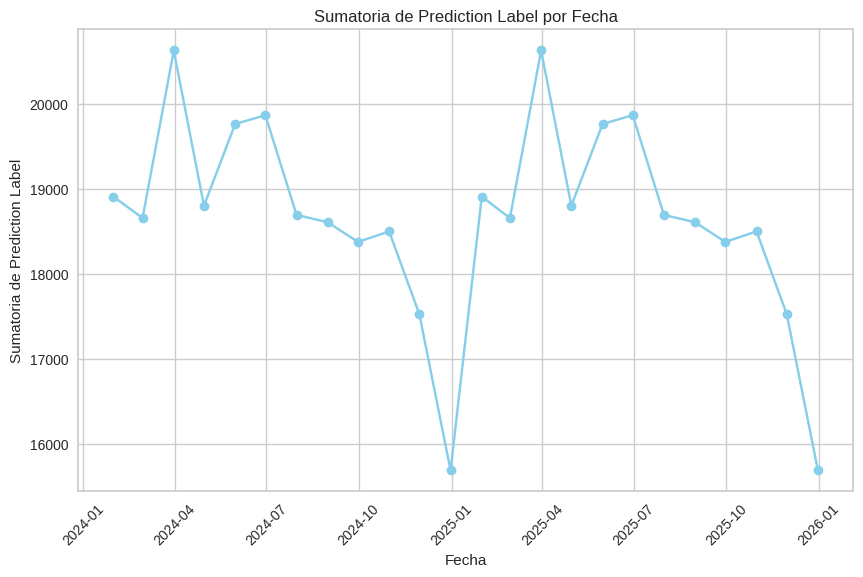

In [79]:
predictions['fecha'] = pd.to_datetime(predictions['fecha'])

# Realizar la sumatoria por fecha
sum_df = predictions.groupby('fecha')['prediction_label'].sum().reset_index()

# Crear el plot
plt.figure(figsize=(10, 6))
plt.plot(sum_df['fecha'], sum_df['prediction_label'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Fecha')
plt.ylabel('Sumatoria de Prediction Label')
plt.title('Sumatoria de Prediction Label por Fecha')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()